## 7.2 A naive attempt with block ciphers

Let's try to build a stream cipher using the tools we already have. Since we already have block ciphers, we could simply divide an incoming stream into different blocks, and encrypt each block. 

This scheme is called **ECB** mode (Electronic Code Book
Mode), and it is one of the many ways that block ciphers can be used to construct stream ciphers.

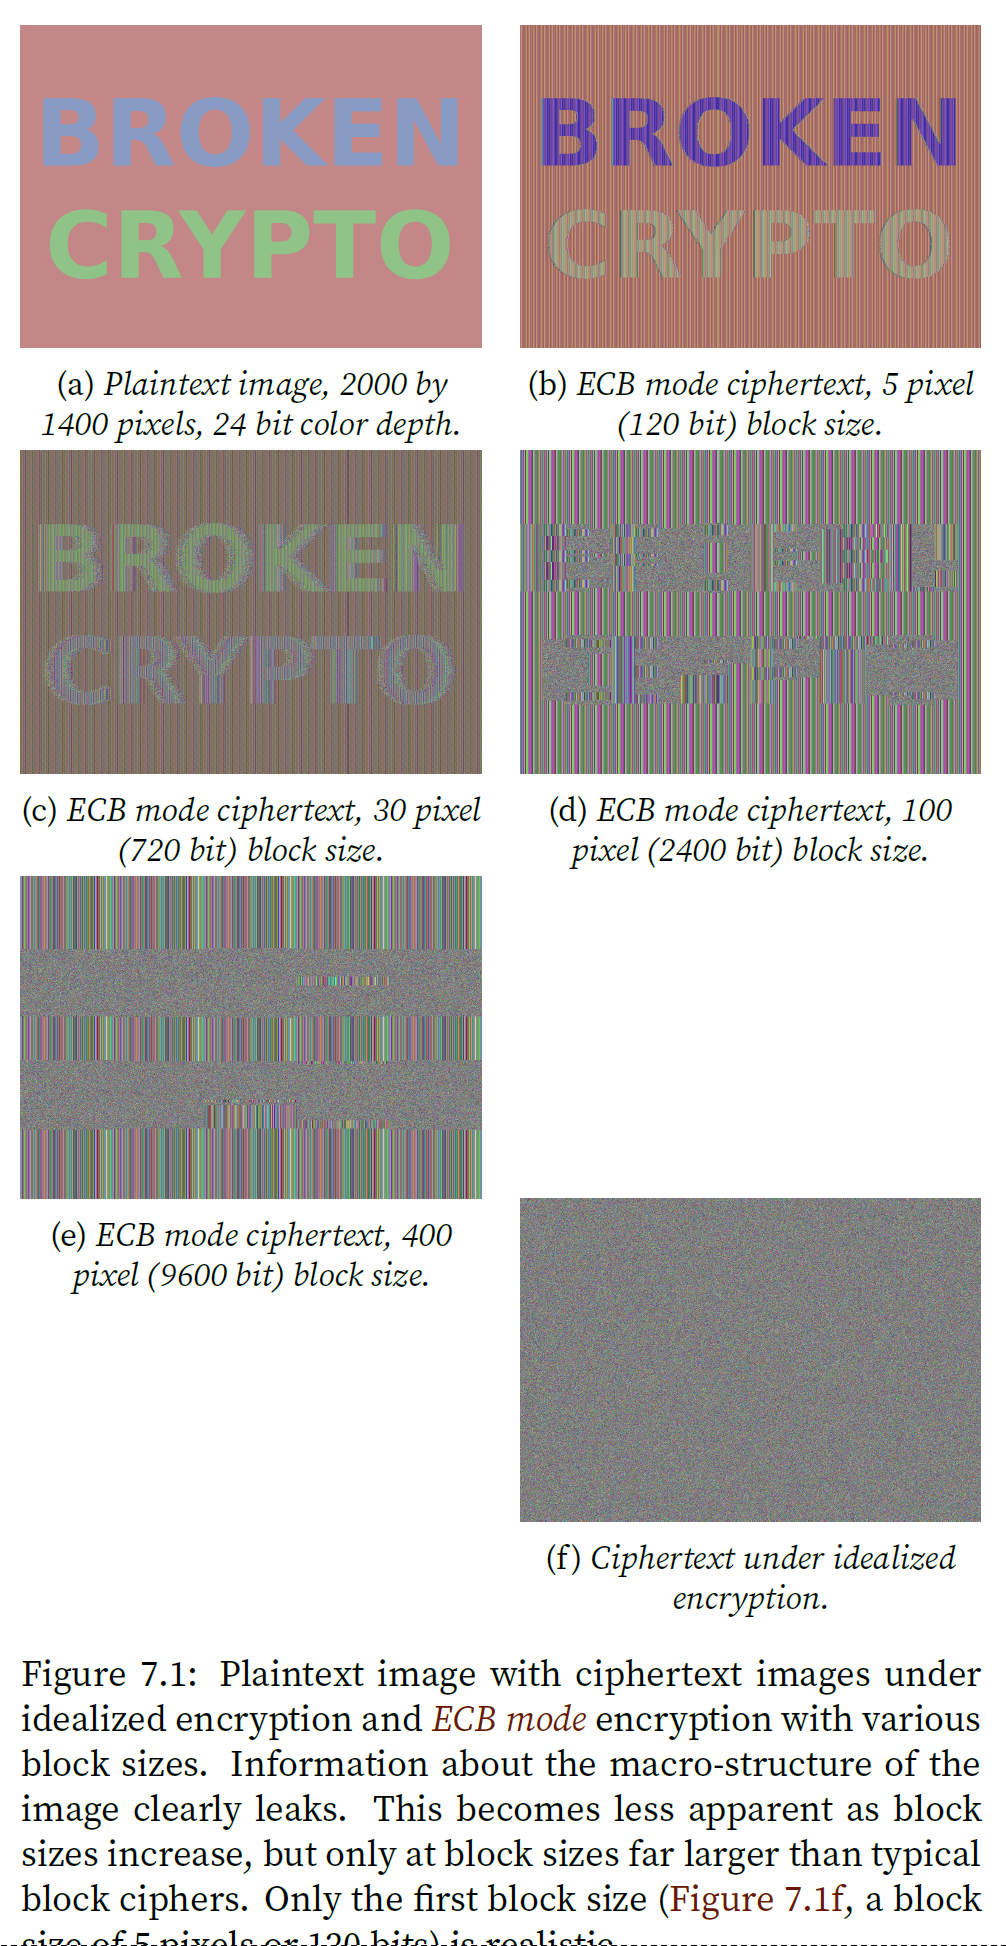

### Encryption oracle attack

To do this, we'll introduce a new concept called an *oracle*. Formally defined *oracles* are used in the study of computer science, but for our purposes it's sufficient to just say that an *oracle* is something that will compute some particular function for you.

the attacker, which is why it's called an *encryption oracle*. Given some data $A$ chosen by the attacker, the oracle will encrypt that data, followed by a secret suffix $S$, in ECB mode. Or, in symbols:
$$C = ECB(E_k,A||S)$$

A simple example would be a cookie encrypted with ECB, where the prefix $A$ is a name or an e-mail address field, controlled by the attacker.

### Decrypting a block using the oracle

The attacker starts by sending in a plaintext $A$ that's just one byte shorter than the block size. That means the block that's being encrypted will consist of those bytes, plus the first byte of $S$, which we'll call $s_0$. The attacker remembers the encrypted block. They don't know the value of $s_0$ yet, but now they do know the value of the first encrypted block: $E_k(A||s_0)$. In the illustration, this is block $CR_1$.

Then, the attacker tries a full-size block, trying all possible values for the final byte. Eventually, they'll find the value of $s_0$; they know the guess is correct because the resulting ciphertext block will match the ciphertext block $CR_1$ they remembered earlier. 

The attacker can repeat this for the penultimate byte. They submit a plaintext $A$ that's two bytes shorter than the block size. The oracle will encrypt a first block consisting of that $A$ followed by the first two bytes of the secret suffix, $s_0s_1$. The attacker remembers that block.

the complex, the brute-force is $p^b$, use this way is $p\cdot b$, where $p$ is the number of possible values for a byte, and $b$ is the block size.

## 7.4 CBC mode

CBC mode, which stands for cipher block **chaining**, is a very common mode of operation where **plaintext** blocks are XORed with the **previous** **ciphertext** block before being encrypted by the block cipher.

While CBC mode itself is not inherently insecure (unlike ECB mode), its particular use in TLS 1.0 was. This eventually led to the BEAST attack, which we'll cover in more detail in the section on SSL/TLS.

## 7.7 CBC bit flipping attacks

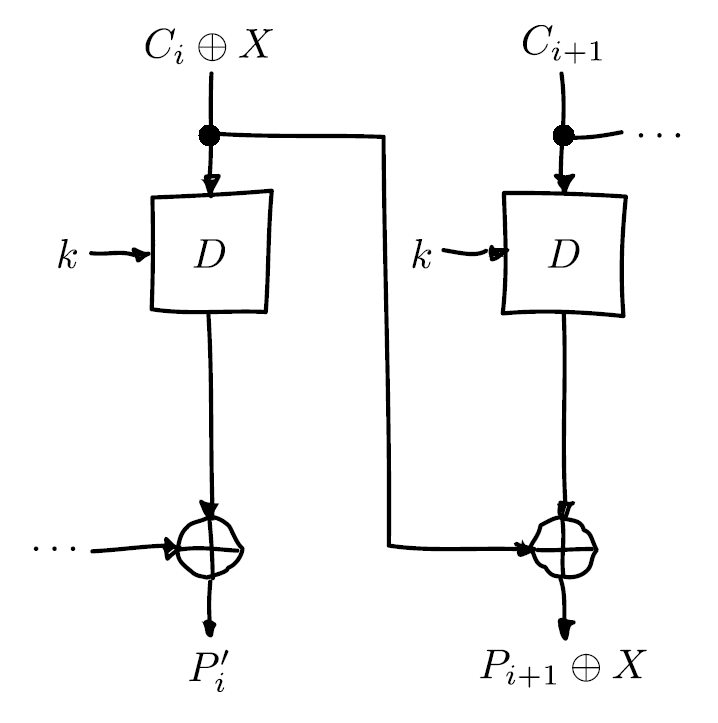

An attacker may have some target bytes that they'd like to see in the decrypted plaintext, for example, ;admin=1;. In order to figure out which bytes they should flip (so, the value of X in the illustration), they just XOR the filler bytes (~ZZZ~…) with that target. Because two XOR operations with the same value cancel each other out, the two filler values (~ZZZ~…) will cancel out, and the attacker can expect to see;admin=1; pop up in the next plaintext block:

$$\begin{split} P′_{i+1} &= P_{i+1} \oplus X \\
&= P_{i+1} \oplus ZZZZZZZZZ \oplus ; admin = 1; \\
&= ZZZZZZZZZ \oplus ZZZZZZZZZ \oplus ; admin = 1; \\ 
&= ; admin = 1;\end{split} \\$$

> Attack steps by modifying the user control level on the cookie:
> 
> 1. Set the username to be long with the value `ZZZZZZZZ`.
> 2. At a specific position, XOR $ZZZZZZZZ \oplus ;admin=1;$. By the XOR property, the result will be `;admin=1;` when the cookie is decrypted on the server.
> 3. As a result, the attacker can gain admin level access.

This attack is another demonstration of an important cryptographic principle: encryption is not **authentication**!

## 7.8 Padding

That means that all messages happen to be a multiple of the block size, which, in a typical block cipher such as AES, is 16 bytes. Of course, real messages can be of arbitrary length. We need some scheme to make them fit.That process is called **padding**.

### Padding with zeroes

This scheme has an obvious flaw: you can't send messages that end in that particular byte value, or you will be unable to distinguish between padding and the actual message.

### PKCS#5/PKCS#7 padding

PKCS#5, PKCS#7 and later CMS padding are all more or less the same idea. Take the number of bytes you have to pad, and pad them with that many times the byte with that value.
For example, if the block size is 8 bytes, and the last block has the three bytes `12 34 45`, the block becomes `12 34 45 05 05 05 05 05` after padding.

## 7.9 CBC padding attacks

It may be helpful to keep in mind that a CBC padding attack does not actually attack the padding for a given message; instead the attacker will be constructing paddings to decrypt a message.

To mount this attack, an attacker only needs two things:
1. A target ciphertext to decrypt
2. A **padding oracle**: a function that takes ciphertexts and tells the attacker if the padding was correct

### Decrypting the first byte

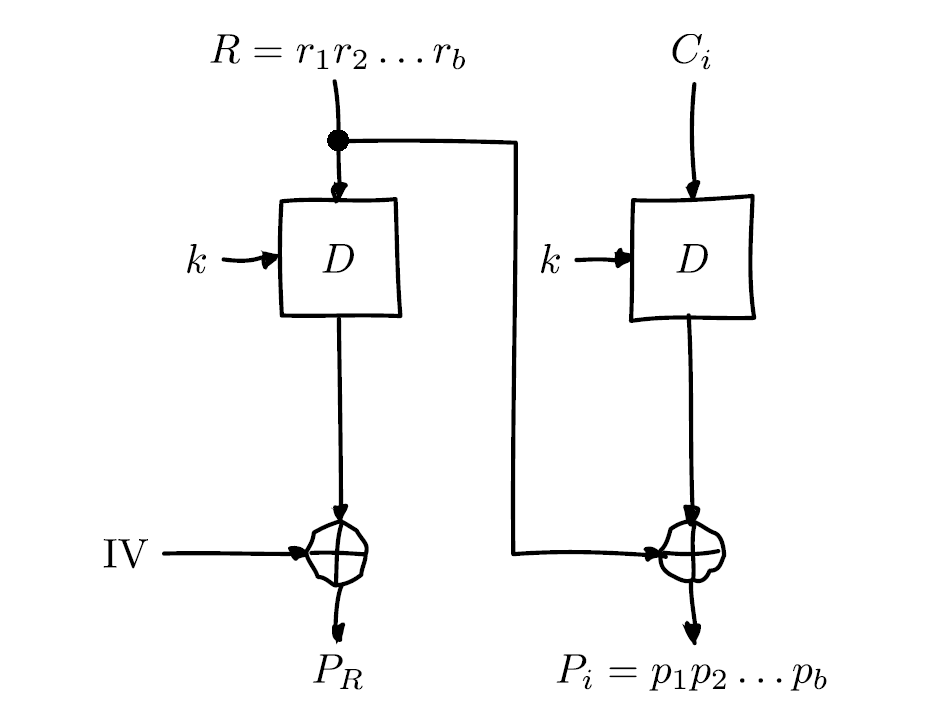

The attacker fills a block with arbitrary bytes $R = r_1, r_2,\dots ,r_b$. They also pick a target block $C_i$ from the ciphertext that they'd like to decrypt. The attacker asks the padding oracle if the plaintext of $R||C_i$ has valid padding.

Next, the attacker tries to modify the message so that it does have valid padding. They can do that by indirectly modifying the last byte of the plaintext: eventually that byte will be `01`, which is always valid padding. In order to modify the last byte of a plaintext block, the attacker modifies the last byte of the previous ciphertext block. This works exactly like it did with CBC bit flipping attacks. That previous ciphertext block is the block $R$, so the byte being modified is the last byte of $R, r_b$.

The attacker knows that the last byte of the decrypted ciphertext block $C_i$ (we'll call that byte $D(C_i)[b]$), XORed with the iteratively found value $r_b$, is `01`:
$$
\begin{split}
D(C_i)[b]\oplus r_b&=01 \\
D(C_i)[b]&=01\oplus r_b
\end{split}
$$

This attack has proven to be very subtle and hard to fix. First of all, messages should be **authenticated**, as well as encrypted. That would cause modified messages to be rejected.